# Imports

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader

from torch.nn.functional import one_hot
from tqdm import tqdm


from models.Blocks import ConvBlock, TransposeConvBlock

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Models

In [20]:
# channel of latent vector
z_dim = 100
n_classes = 10

In [21]:
class Discriminator(nn.Module):
    def __init__(self, n_classes, hidden_c):
        super().__init__()
        # B x 1 x 28 x 28 -> B x 64 x 28 x 28
        self.input_layer = ConvBlock(in_channel=1, out_channel=hidden_c, ksize=5, stride=1)
        
        self.hidden_layers = nn.Sequential(
            # B x 64 x 28 x 28 -> B x 128 x 14 x 14
            ConvBlock(in_channel=1 * hidden_c, out_channel=2 * hidden_c, ksize=3, stride=1, downsample=True),
            # B x 128 x 14 x 14 -> B x 256 x 14 x 14 
            ConvBlock(in_channel=2 * hidden_c, out_channel=4 * hidden_c, ksize=3, stride=1),
            # B x 256 x 14 x 14 -> B x 512 x 7 x 7
            ConvBlock(in_channel=4 * hidden_c, out_channel=8 * hidden_c, ksize=3, stride=1, downsample=True),
        )
        self.output_layer = nn.Sequential(
            # B x 512 x 7 x 7 -> B x 100 x 7 x 7
            ConvBlock(in_channel=8 * hidden_c, out_channel=z_dim + n_classes, ksize=1, stride=1),
        )
        self.z_layer = nn.Sequential(
            # B x 100 x 7 x 7 -> B x 100 x 1 x 1
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            # B x 100 x 1 x 1 -> B x 1
            nn.Linear(z_dim + n_classes, 1),
            nn.Sigmoid()
        )

        self.c_layer = nn.Sequential(
            # B x 100 -> B x 10 x 7 x 7
            nn.Conv2d(z_dim + n_classes, n_classes, 1, 1),
            nn.BatchNorm2d(10),
            # B x 10 x 7 x 7 -> B x 10 x 1 x 1
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        

    def forward(self, x):
        out = self.input_layer(x)
        out = self.hidden_layers(out)
        out = self.output_layer(out)

        z = self.z_layer(out)
        c = self.c_layer(out)

        return z, c
        

In [22]:
class Generator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.input_layer = nn.Sequential(
            # B x 100 x 1 x 1 -> B x 100 x 7 x 7 
            TransposeConvBlock(z_dim + n_classes, z_dim + n_classes, ksize=7, stride=1),
            # B x 100 x 7 x 7 -> B x 512 x 7 x 7
            TransposeConvBlock(z_dim + n_classes, 8 * hidden_dim, upsample=False),
        )
        self.hidden_layers = nn.Sequential(
            # B x 512 x 7 x 7 -> B x 256 x 14 x 14
            TransposeConvBlock(8 * hidden_dim, 4 * hidden_dim, upsample=True),
            # B x 256 x 14 x 14 -> B x 128 x 14 x 14
            TransposeConvBlock(4 * hidden_dim, 2 * hidden_dim, upsample=False),
            # B x 128 x 14 x 14 -> B x 64 x 28 x 28
            TransposeConvBlock(2 * hidden_dim, 1 * hidden_dim, upsample=True),
        )
        self.output_layer = nn.Sequential(
            nn.Conv2d(hidden_dim, 1, kernel_size=1),
            nn.Tanh()
        )

    def forward(self, x, c):
        out = torch.cat((x, c), dim=1)

        out = self.input_layer(out)
        out = self.hidden_layers(out)
        out = self.output_layer(out)

        return out

# Data

In [29]:
BATCH_SIZE = 64

dataset = dset.MNIST(
    root="./data/",
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    download=True
)


data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=8,
    shuffle=True,
    drop_last=True
)

# Train

In [30]:
device = torch.device("cuda")

G = Generator(hidden_dim=128).to(device)
D = Discriminator(n_classes=10, hidden_c=128).to(device)

bce_criterion = nn.BCELoss().to(device)
ce_criterion = nn.CrossEntropyLoss().to(device)
D_optimizer = optim.Adam(params=D.parameters(), lr=1e-3)
G_optimizer = optim.Adam(params=G.parameters(), lr=2e-4)

K_D = 1
K_G = 1
epochs = 10


99it [00:26,  3.80it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100it [00:26,  3.60it/s]

epoch:   1 avgLoss_D_S_real: 0.3863 avgLoss_D_S_fake: 0.3745 avgLoss_D_C_real: 0.9344 avgLoss_D_C_fake: 0.3665 avgLoss_G_S: 1.1826 avgLoss_G_C: 0.3841


199it [00:52,  3.70it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
200it [00:53,  3.48it/s]

epoch:   1 avgLoss_D_S_real: 0.1174 avgLoss_D_S_fake: 0.1280 avgLoss_D_C_real: 0.7413 avgLoss_D_C_fake: 0.3619 avgLoss_G_S: 2.1455 avgLoss_G_C: 0.3194


299it [01:19,  3.77it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
300it [01:20,  3.52it/s]

epoch:   1 avgLoss_D_S_real: 0.0636 avgLoss_D_S_fake: 0.0572 avgLoss_D_C_real: 0.7692 avgLoss_D_C_fake: 0.4135 avgLoss_G_S: 2.9734 avgLoss_G_C: 0.3591


399it [01:46,  3.74it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
400it [01:47,  3.58it/s]

epoch:   1 avgLoss_D_S_real: 0.0437 avgLoss_D_S_fake: 0.0478 avgLoss_D_C_real: 0.5801 avgLoss_D_C_fake: 0.4122 avgLoss_G_S: 3.0868 avgLoss_G_C: 0.4079


499it [02:13,  3.68it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
500it [02:14,  3.48it/s]

epoch:   1 avgLoss_D_S_real: 0.1603 avgLoss_D_S_fake: 0.0933 avgLoss_D_C_real: 0.7186 avgLoss_D_C_fake: 0.7303 avgLoss_G_S: 2.3697 avgLoss_G_C: 0.7036


599it [02:40,  3.78it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
600it [02:40,  3.54it/s]

epoch:   1 avgLoss_D_S_real: 0.0572 avgLoss_D_S_fake: 0.0251 avgLoss_D_C_real: 0.5134 avgLoss_D_C_fake: 0.6001 avgLoss_G_S: 3.7366 avgLoss_G_C: 0.5661


699it [03:07,  3.78it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
700it [03:07,  3.54it/s]

epoch:   1 avgLoss_D_S_real: 0.0682 avgLoss_D_S_fake: 0.2204 avgLoss_D_C_real: 0.4137 avgLoss_D_C_fake: 0.5270 avgLoss_G_S: 2.9569 avgLoss_G_C: 0.4505


799it [03:33,  3.79it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
800it [03:34,  3.62it/s]

epoch:   1 avgLoss_D_S_real: 0.0788 avgLoss_D_S_fake: 0.0713 avgLoss_D_C_real: 0.4763 avgLoss_D_C_fake: 0.5769 avgLoss_G_S: 2.0731 avgLoss_G_C: 0.5943


899it [04:00,  3.80it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
900it [04:00,  3.63it/s]

epoch:   1 avgLoss_D_S_real: 0.0603 avgLoss_D_S_fake: 0.0150 avgLoss_D_C_real: 0.3695 avgLoss_D_C_fake: 0.4029 avgLoss_G_S: 4.2962 avgLoss_G_C: 0.4046


937it [04:10,  3.74it/s]
99it [00:26,  3.75it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100it [00:26,  3.58it/s]

epoch:   2 avgLoss_D_S_real: 0.0771 avgLoss_D_S_fake: 0.0823 avgLoss_D_C_real: 0.3129 avgLoss_D_C_fake: 0.3801 avgLoss_G_S: 3.0875 avgLoss_G_C: 0.3918


110it [00:29,  3.70it/s]


KeyboardInterrupt: 

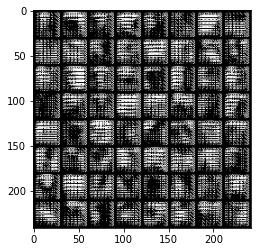

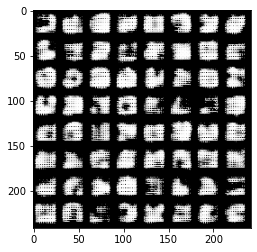

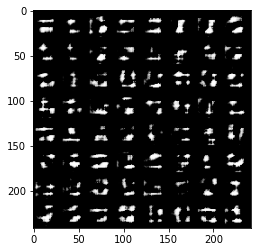

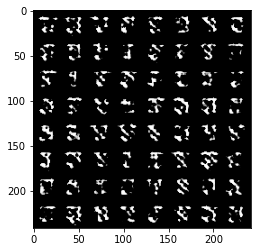

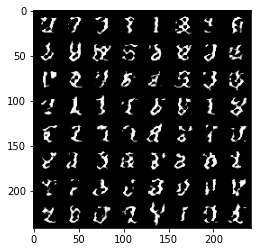

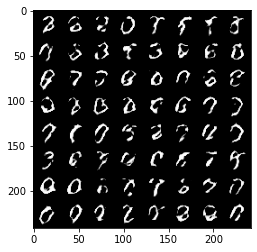

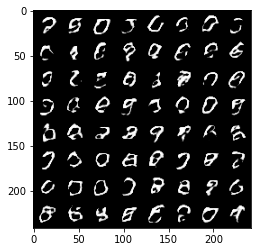

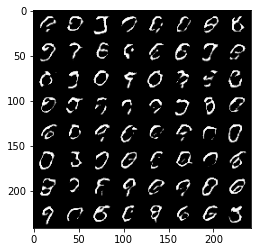

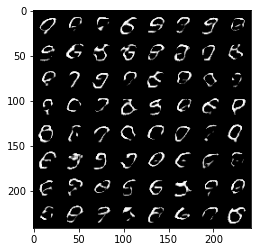

In [31]:
total_batch = len(data_loader)
img_list = []

for epoch in range(epochs):
    avgLoss_D_S_real = 0
    avgLoss_D_S_fake = 0
    avgLoss_D_C_real = 0
    avgLoss_D_C_fake = 0
    avgLoss_G_S = 0
    avgLoss_G_C = 0

    for i, (X, Y) in tqdm(enumerate(data_loader)):
        X = X.to(device)
        Y = Y.to(device)

        Y = one_hot(Y, num_classes=n_classes)
        for _ in range(K_D):
            noise = torch.randn(BATCH_SIZE, z_dim, device=device)
            noise = noise.view(BATCH_SIZE, z_dim, 1, 1)

            fake = G(noise, Y.view(-1, n_classes, 1, 1))

            z_real, c_real = D(X)

            real_label = torch.ones((BATCH_SIZE, 1), dtype=torch.float, device=device)
            lossS_real = bce_criterion(z_real, real_label.detach())    
            lossC_real = ce_criterion(c_real, Y.float())

            z_fake, c_fake = D(fake.detach())

            fake_label = torch.zeros((BATCH_SIZE, 1), dtype=torch.float, device=device)
            lossS_fake = bce_criterion(z_fake, fake_label.detach())
            lossC_fake = ce_criterion(c_fake, Y.float())

            lossS = (lossS_real + lossS_fake) / 2
            lossC = (lossC_real + lossC_fake) / 2
            lossD = lossS + lossC

            D.zero_grad()
            lossD.backward()
            D_optimizer.step()

        for _ in range(K_G):
            noise = torch.randn(BATCH_SIZE, z_dim, device=device)
            noise = noise.view(BATCH_SIZE, z_dim, 1, 1)
            fake = G(noise, Y.view(-1, n_classes, 1, 1))
            real_label_G = torch.zeros((BATCH_SIZE, 1), dtype=torch.float, device=device)

            z_fake2, c_fake2 = D(fake)
            lossG_S = bce_criterion(1 - z_fake2, real_label_G.detach())
            lossG_C = ce_criterion(c_fake2, Y.float())
            lossG = lossG_S + lossG_C

            G.zero_grad()
            lossG.backward()
            G_optimizer.step()

        avgLoss_D_S_real += lossS_real.mean().item() / total_batch
        avgLoss_D_S_fake += lossS_fake.mean().item() / total_batch
        avgLoss_D_C_real += lossC_real.mean().item() / total_batch
        avgLoss_D_C_fake += lossC_fake.mean().item() / total_batch
        avgLoss_G_S += lossG_S.mean().item() / total_batch
        avgLoss_G_C += lossG_C.mean().item() / total_batch

        if (i+1) % 100 == 0:
            print(f"epoch: {epoch+1:3d} avgLoss_D_S_real: {lossS_real:.4f} avgLoss_D_S_fake: {lossS_fake:.4f} avgLoss_D_C_real: {lossC_real:.4f} avgLoss_D_C_fake: {lossC_fake:.4f} avgLoss_G_S: {lossG_S:.4f} avgLoss_G_C: {lossG_C:.4f}")
            img_list.append(fake)
            generate_example(G)



# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

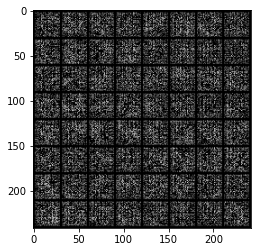

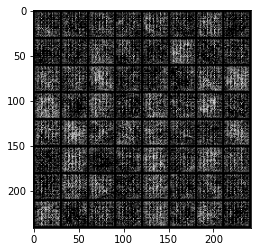

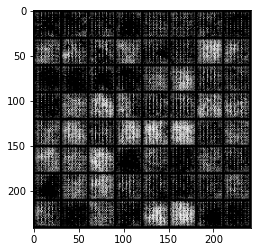

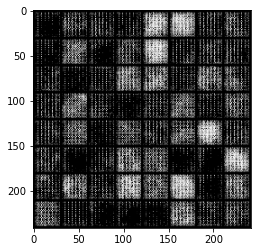

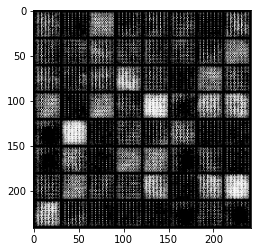

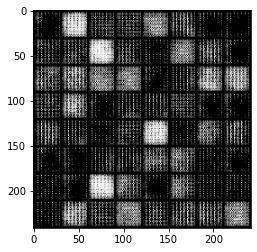

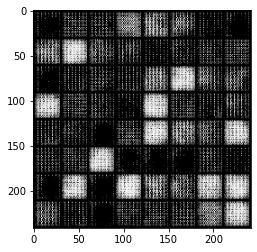

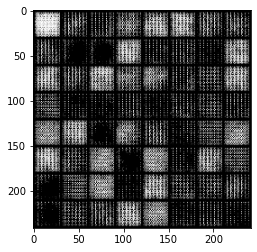

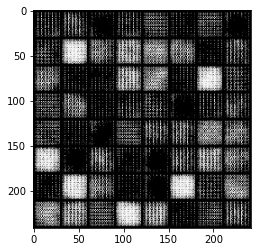

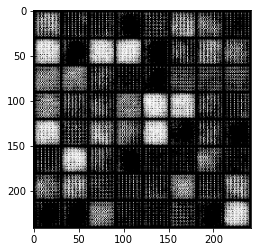

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline


for i, img in enumerate(img_list):
    img = torchvision.utils.make_grid(img)
    img = img.detach().cpu().numpy()
    img = img.transpose(1, 2, 0)
    plt.figure(i)
    plt.imshow(img)


# creating images in each classes

In [27]:
def generate_example(G):
    noise = torch.randn(BATCH_SIZE, z_dim, device="cuda")
    noise = noise.view(BATCH_SIZE, z_dim, 1, 1)

    number = 0
    code1 = one_hot(torch.ones((BATCH_SIZE), dtype=int) * number, num_classes=n_classes).cuda()

    imgs = G(noise, code1.view(-1, n_classes, 1, 1))

    img = torchvision.utils.make_grid(imgs)
    img = img.detach().cpu().numpy()
    img = img.transpose(1, 2, 0)
    plt.figure(i)
    plt.imshow(img)


In [28]:
a = torch.FloatTensor([1, 1, 1])

In [33]:
torch.cuda.is_available()

True

: 